<a href="https://colab.research.google.com/github/Vastav1812/ML-Prediction-Model/blob/main/MLPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install xgboost
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install pyxlsb


In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score


In [4]:
from google.colab import files
uploaded = files.upload()

Saving 202304.xlsb to 202304.xlsb
Saving 202305.xlsb to 202305.xlsb
Saving 202306.xlsb to 202306.xlsb
Saving 202307.xlsb to 202307.xlsb
Saving 202308.xlsb to 202308.xlsb
Saving 202309.xlsb to 202309.xlsb
Saving 202310.xlsb to 202310.xlsb
Saving 202311.xlsb to 202311.xlsb
Saving 202312.xlsb to 202312.xlsb
Saving 202401.xlsb to 202401.xlsb
Saving 202402.xlsb to 202402.xlsb
Saving 202403.xlsb to 202403.xlsb


In [5]:
# Function to load and combine .xlsb files
def load_and_combine_xlsb(files):
    combined_data = pd.DataFrame()
    for file in files:
        df = pd.read_excel(file, engine='pyxlsb')
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    return combined_data

# File paths from your environment
file_paths = [
    '202304.xlsb', '202305.xlsb', '202306.xlsb',
    '202307.xlsb', '202308.xlsb', '202309.xlsb',
    '202310.xlsb', '202311.xlsb', '202312.xlsb',
    '202401.xlsb', '202402.xlsb', '202403.xlsb'
]

# Load and combine files
data = load_and_combine_xlsb(file_paths)

# Check the first few rows
print(data.head())


       id unique_id                         date     beno    hscode  \
0  414190  2304_223  2023-04-05T00:00:00.0000000  5381617  39012000   
1  414191  2304_224  2023-04-06T00:00:00.0000000  5392284  39012000   
2  414192  2304_225  2023-04-09T00:00:00.0000000  5439235  39019000   
3  414193  2304_226  2023-04-18T00:00:00.0000000  5566659  39012000   
4  414194  2304_227  2023-04-18T00:00:00.0000000  5570918  39012000   

                                           prod_desc  data_key company  \
0  HDPE REPROCESSE GRANULES (C. NO. KL-2023-AI-21...       NaN       0   
1                                        HDPE HF1881       NaN   SHARQ   
2  POLYETHYLENE CL BLACK MASTERBATCH BK00016 BATC...       NaN       0   
3  HDPE REGRIND (NON HAZARDOUS) ASEAN NO KL-2023-...       NaN       0   
4                             HDPE REGRIND (RECYCLE)       NaN       0   

  product fbt_category  ...      fin_cif fin_qty unitrate_inr unitrate_usd  \
0   OTHER          NaN  ...   818.250000  54.000  

In [6]:
# Drop rows with missing values in important columns
data_cleaned = data.dropna(subset=['unitrate_inr', 'total_duty_be', 'fin_qty', 'unitrate_usd'])

# Convert date to datetime
data_cleaned['date'] = pd.to_datetime(data_cleaned['date'])

# Create new time-based features
data_cleaned['year'] = data_cleaned['date'].dt.year
data_cleaned['month'] = data_cleaned['date'].dt.month
data_cleaned['day_of_week'] = data_cleaned['date'].dt.dayofweek

# Lag features (previous values of the target variables)
data_cleaned['lagged_unitrate_inr'] = data_cleaned['unitrate_inr'].shift(1)
data_cleaned['lagged_total_duty_be'] = data_cleaned['total_duty_be'].shift(1)

# Interaction terms (fin_qty * unitrate_usd)
data_cleaned['interaction_qty_usd'] = data_cleaned['fin_qty'] * data_cleaned['unitrate_usd']

# Fill NaN values generated by lagging with 0 (or another strategy like forward fill)
data_cleaned.fillna(0, inplace=True)

# Convert categorical columns to numeric
data_cleaned = pd.get_dummies(data_cleaned, columns=['company', 'product', 'shipment_mode'], drop_first=True)

# Check the cleaned and engineered data
print(data_cleaned.head())


       id unique_id       date     beno    hscode  \
0  414190  2304_223 2023-04-05  5381617  39012000   
1  414191  2304_224 2023-04-06  5392284  39012000   
2  414192  2304_225 2023-04-09  5439235  39019000   
3  414193  2304_226 2023-04-18  5566659  39012000   
4  414194  2304_227 2023-04-18  5570918  39012000   

                                           prod_desc  data_key fbt_category  \
0  HDPE REPROCESSE GRANULES (C. NO. KL-2023-AI-21...       0.0            0   
1                                        HDPE HF1881       0.0            0   
2  POLYETHYLENE CL BLACK MASTERBATCH BK00016 BATC...       0.0            0   
3  HDPE REGRIND (NON HAZARDOUS) ASEAN NO KL-2023-...       0.0            0   
4                             HDPE REGRIND (RECYCLE)       0.0            0   

              grade          sector  ... product_Other product_PE product_POE  \
0  HDPE REPROCESSED  HD-REPROCESSED  ...         False      False       False   
1           HDPE F1         HM FILM  ...    

In [7]:
# Define features and target variables
features = data_cleaned[['fin_qty', 'unitrate_usd', 'year', 'month', 'day_of_week',
                         'lagged_unitrate_inr', 'lagged_total_duty_be', 'interaction_qty_usd'] +
                        [col for col in data_cleaned.columns if col.startswith('company_') or col.startswith('product_') or col.startswith('shipment_mode_')]]
targets = data_cleaned[['unitrate_inr', 'total_duty_be']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Separate the targets
y_train_unitrate = y_train['unitrate_inr']
y_train_duty = y_train['total_duty_be']
y_test_unitrate = y_test['unitrate_inr']
y_test_duty = y_test['total_duty_be']


In [8]:
# Initialize the XGBoost model
model_unitrate = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model_duty = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

# Train the models
model_unitrate.fit(X_train, y_train_unitrate)
model_duty.fit(X_train, y_train_duty)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8]
}

# Initialize GridSearchCV for both models
grid_search_unitrate = GridSearchCV(estimator=model_unitrate, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search_duty = GridSearchCV(estimator=model_duty, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Perform GridSearch
grid_search_unitrate.fit(X_train, y_train_unitrate)
grid_search_duty.fit(X_train, y_train_duty)

# Best parameters
print("Best parameters for unitrate_inr:", grid_search_unitrate.best_params_)
print("Best parameters for total_duty_be:", grid_search_duty.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for unitrate_inr: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000}
Best parameters for total_duty_be: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}


In [10]:
# Predicting on the test set
y_pred_unitrate = model_unitrate.predict(X_test)
y_pred_duty = model_duty.predict(X_test)

# Evaluation Metrics
mse_unitrate = mean_squared_error(y_test_unitrate, y_pred_unitrate)
mae_unitrate = mean_absolute_error(y_test_unitrate, y_pred_unitrate)
r2_unitrate = model_unitrate.score(X_test, y_test_unitrate)

mse_duty = mean_squared_error(y_test_duty, y_pred_duty)
mae_duty = mean_absolute_error(y_test_duty, y_pred_duty)
r2_duty = model_duty.score(X_test, y_test_duty)

print(f"Unitrate INR - MSE: {mse_unitrate}, MAE: {mae_unitrate}, R2: {r2_unitrate}")
print(f"Total Duty BE - MSE: {mse_duty}, MAE: {mae_duty}, R2: {r2_duty}")


Unitrate INR - MSE: 6380293.582215412, MAE: 294.73395288969084, R2: 0.997210028548556
Total Duty BE - MSE: 211486347534.8854, MAE: 220136.43906627016, R2: 0.9058475400232392


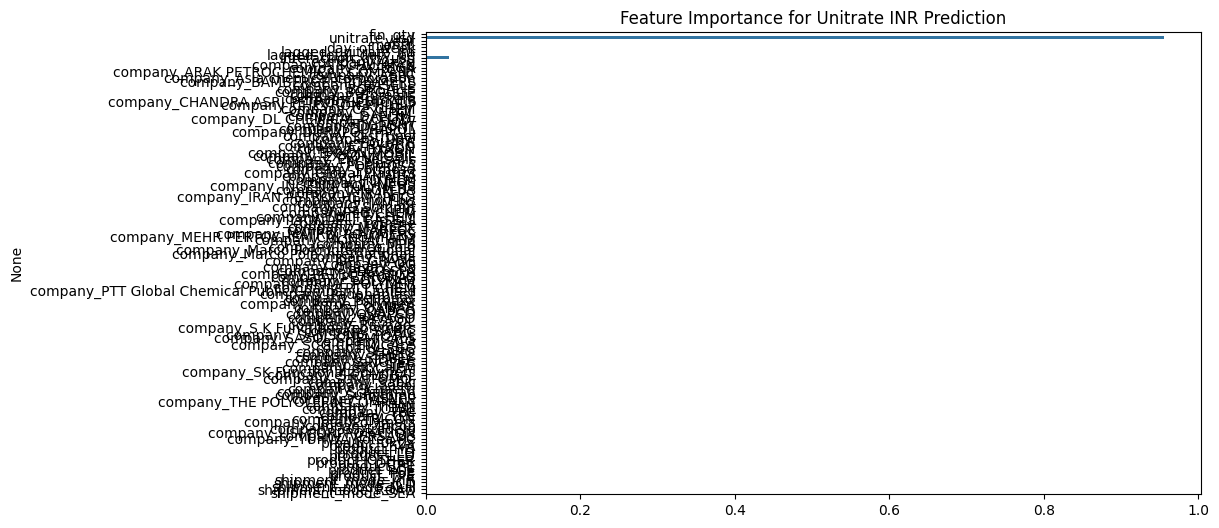

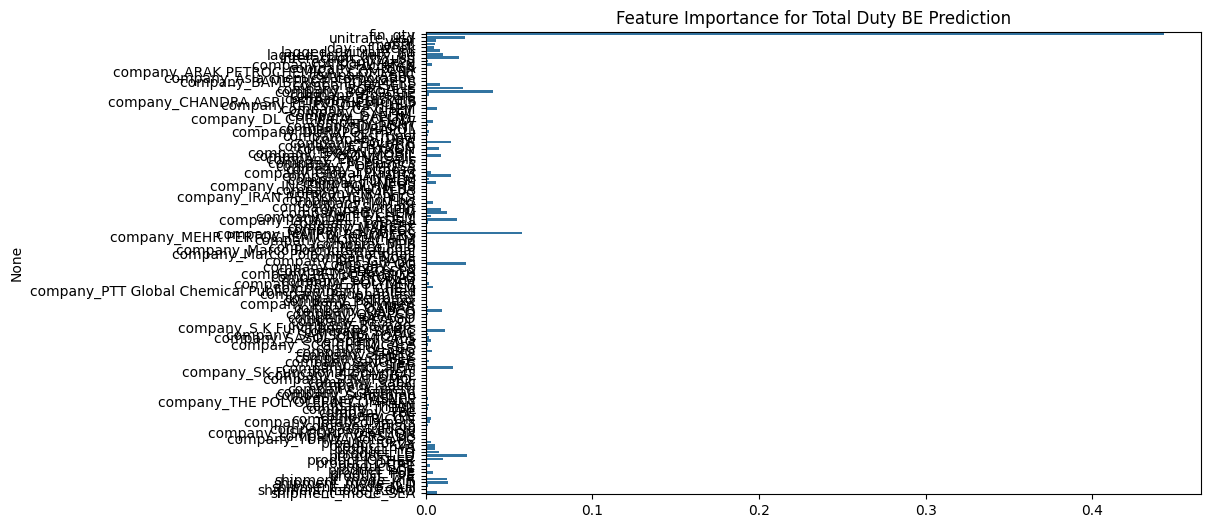

In [11]:
# Plot feature importances
importances_unitrate = model_unitrate.feature_importances_
importances_duty = model_duty.feature_importances_

# Plotting feature importance for unitrate_inr
plt.figure(figsize=(10,6))
sns.barplot(x=importances_unitrate, y=features.columns)
plt.title('Feature Importance for Unitrate INR Prediction')
plt.show()

# Plotting feature importance for total_duty_be
plt.figure(figsize=(10,6))
sns.barplot(x=importances_duty, y=features.columns)
plt.title('Feature Importance for Total Duty BE Prediction')
plt.show()


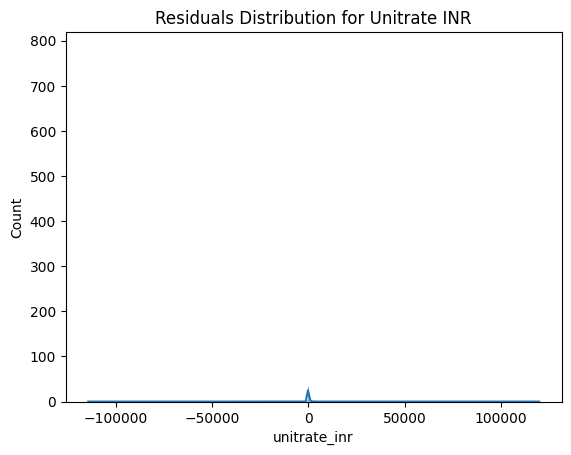

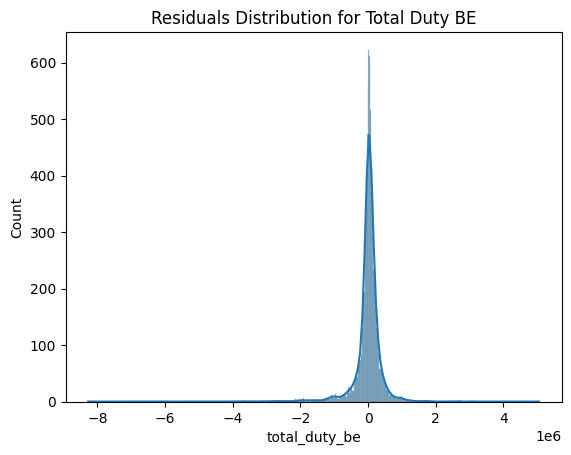

In [12]:
# Plot residuals for unitrate_inr
residuals_unitrate = y_test_unitrate - y_pred_unitrate
sns.histplot(residuals_unitrate, kde=True)
plt.title('Residuals Distribution for Unitrate INR')
plt.show()

# Plot residuals for total_duty_be
residuals_duty = y_test_duty - y_pred_duty
sns.histplot(residuals_duty, kde=True)
plt.title('Residuals Distribution for Total Duty BE')
plt.show()


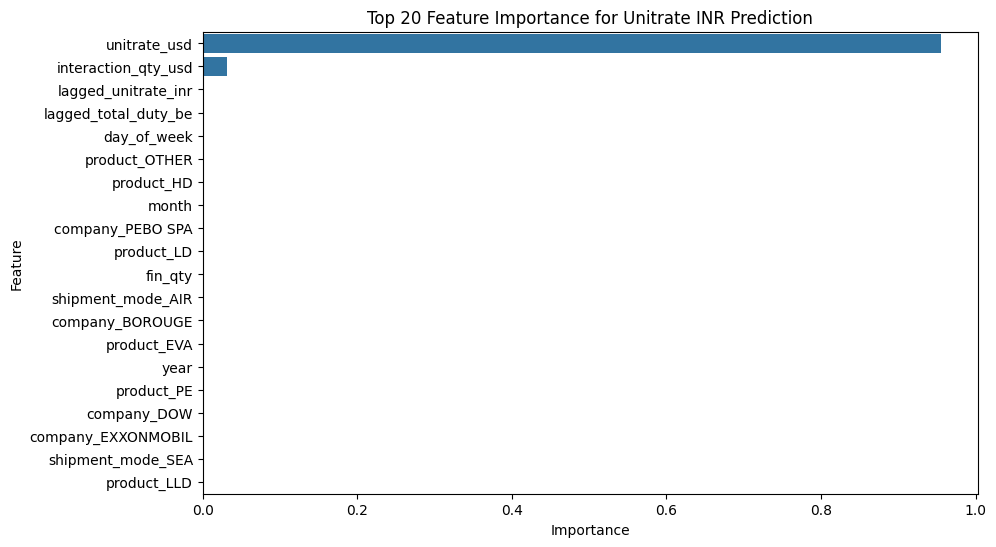

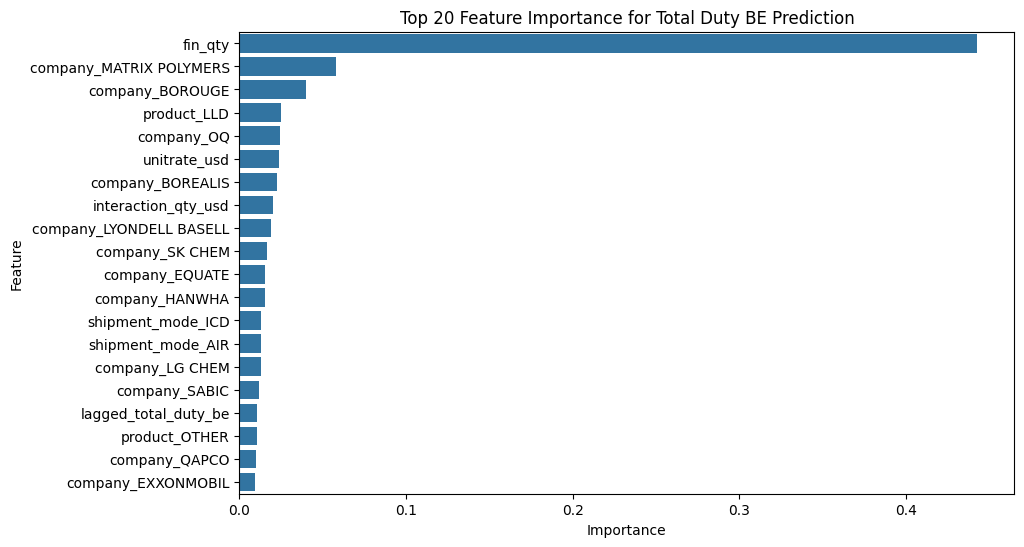

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot feature importances for a given target
def plot_feature_importance(importances, feature_names, target_name, top_n=20):
    # Create a DataFrame for the features and their importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort the DataFrame by the Importance column
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Select the top N most important features
    top_features = feature_importance_df.head(top_n)

    # Plot the top N feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Feature Importance for {target_name} Prediction')
    plt.show()

# Plot feature importances for unitrate_inr (Unitrate INR Prediction)
importances_unitrate = model_unitrate.feature_importances_
plot_feature_importance(importances_unitrate, features.columns, 'Unitrate INR', top_n=20)

# Plot feature importances for total_duty_be (Total Duty BE Prediction)
importances_duty = model_duty.feature_importances_
plot_feature_importance(importances_duty, features.columns, 'Total Duty BE', top_n=20)


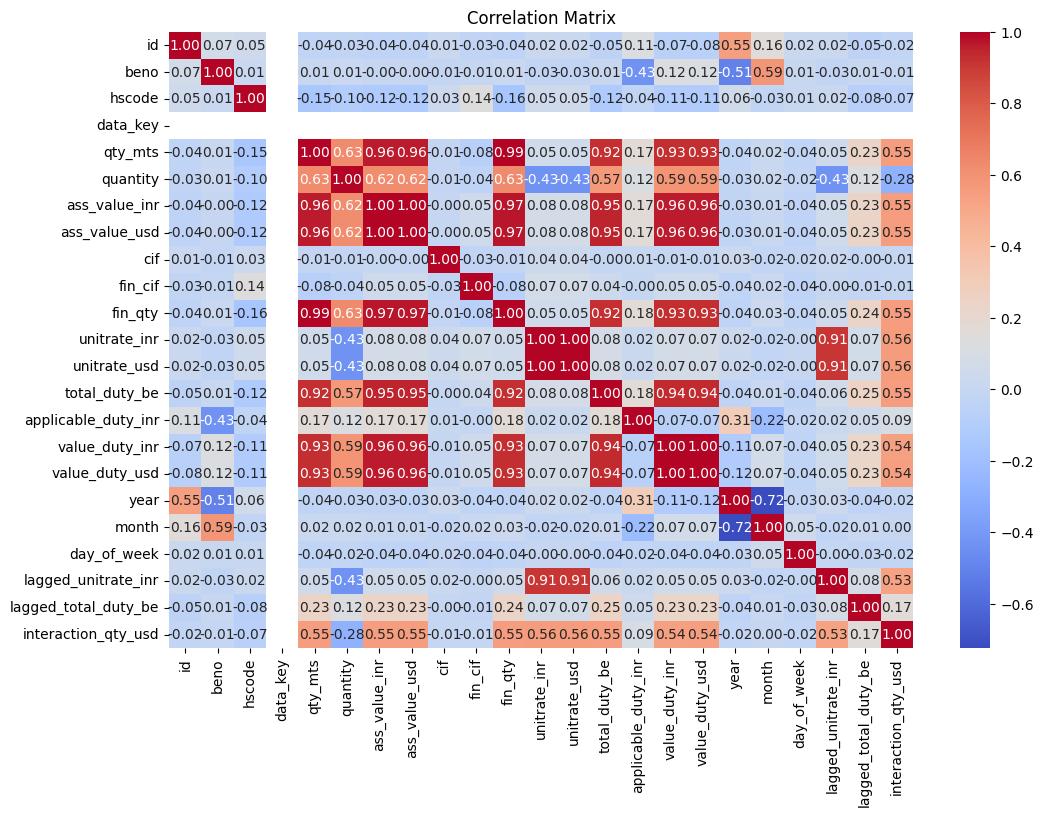

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns before calculating correlation
numeric_data = data_cleaned.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()  # Calculate correlation on numeric data only
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()